# distribution plot

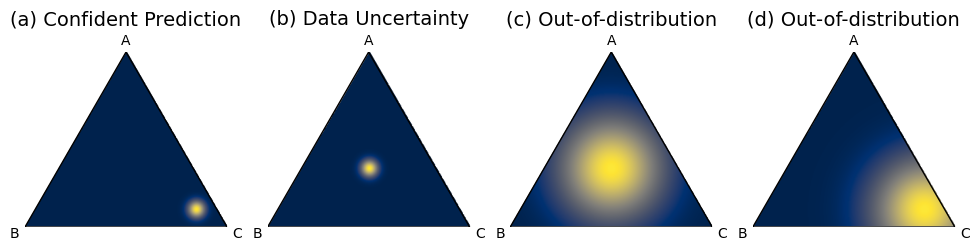

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import string

# === Utility: regular polygon vertices ===
def regular_polygon_vertices(n, radius=1, rotation=None):
	"""Generate vertices of a regular n-sided polygon."""
	if rotation is None:
		# Default rotation: make base horizontal for odd polygons like triangles
		if n == 3:
			rotation = np.pi / 2  # rotate so base is horizontal
		elif n % 2 == 0:
			rotation = np.pi / n  # align top vertex for even polygons
		else:
			rotation = np.pi / 2
	angles = np.linspace(0, 2*np.pi, n, endpoint=False) + rotation
	return np.c_[np.cos(angles), np.sin(angles)] * radius

# === Generic polygon plotter ===
def plot_polygon_distribution(ax, n_sides, dist_func, cmap='cividis', resolution=300, label_vertices=True):
	vertices = regular_polygon_vertices(n_sides)
	path = Path(vertices)

	# Grid of points covering bounding box
	x = np.linspace(vertices[:,0].min(), vertices[:,0].max(), resolution)
	y = np.linspace(vertices[:,1].min(), vertices[:,1].max(), resolution)
	X, Y = np.meshgrid(x, y)
	points = np.c_[X.ravel(), Y.ravel()]

	# Mask outside polygon
	mask = path.contains_points(points)

	# Apply distribution only inside polygon
	Z = np.full(points.shape[0], np.nan)
	Z[mask] = dist_func(points[mask])

	# Reshape and plot
	Z = Z.reshape(X.shape)
	
	# You can use any matplotlib colormap. Some common options are:
	# 'viridis', 'plasma', 'inferno', 'magma', 'cividis', 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
	# 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'
	# For diverging: 'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic'
	ax.imshow(Z, origin='lower', extent=(x.min(), x.max(), y.min(), y.max()), cmap=cmap)
	ax.add_patch(plt.Polygon(vertices, closed=True, fill=False, edgecolor='k', linewidth=1))
	ax.set_aspect('equal')
	ax.axis('off')

	# Label vertices alphabetically
	if label_vertices:
		labels = string.ascii_uppercase[:n_sides]
		for i, (vx, vy) in enumerate(vertices):
			ax.text(vx*1.1, vy*1.1, labels[i], fontsize=10, 
					ha='center', va='center', color='black',
					bbox=dict(facecolor='white', edgecolor='none', boxstyle='circle,pad=0.15'))

# === Distributions ===
def gaussian_peak(points, center=(1,0), spread=0.05):
	"""Gaussian bump around a given center with specified spread."""
	return np.exp(-np.sum((points - np.array(center))**2, axis=1) / (2*spread**2))

def uniform_distribution(points):
	"""Flat uniform distribution."""
	return np.ones(points.shape[0])

# === Parameters ===
n_classes = 3

# === Plot ===
fig, axs = plt.subplots(1, 4, figsize=(12, 3))

plot_polygon_distribution(axs[0], n_classes, lambda pts: gaussian_peak(pts, center=(0.6, -0.35), spread=0.05))
axs[0].set_title("(a) Confident Prediction")

plot_polygon_distribution(axs[1], n_classes, lambda pts: gaussian_peak(pts, center=(0, 0), spread=0.05))
axs[1].set_title("(b) Data Uncertainty")

plot_polygon_distribution(axs[2], n_classes, lambda pts: gaussian_peak(pts, center=(0, 0), spread=0.30))
axs[2].set_title("(c) Out-of-distribution")

plot_polygon_distribution(axs[3], n_classes, lambda pts: gaussian_peak(pts, center=(0.6, -0.35), spread=0.30))
axs[3].set_title("(d) Out-of-distribution")

for ax in axs:
	ax.set_title(ax.get_title(), pad=20, fontsize=14)  # push all subplot titles down
	


# plt.tight_layout()
plt.savefig("plots/distributional_uncertainty.pdf", dpi=300)
plt.show()


# bounds plot

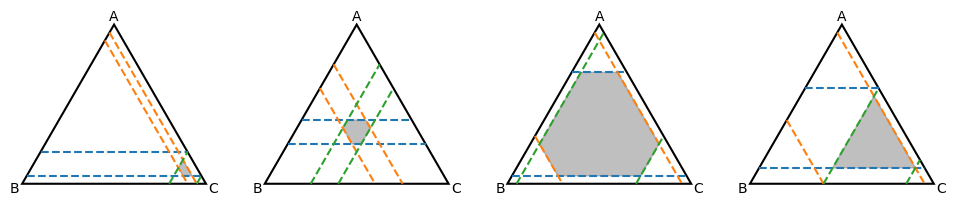

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import string

def regular_polygon_vertices(n, radius=1, rotation=np.pi/2):
	angles = np.linspace(0, 2*np.pi, n, endpoint=False) + rotation
	return np.c_[np.cos(angles), np.sin(angles)] * radius

def prob_to_cartesian(prob, vertices):
	return np.dot(prob, vertices)

def clip_polygon_against_bound(poly, class_idx, bound, is_lower):
	"""Clip polygon in probability space against p[class_idx] >= bound (is_lower=True)
	   or p[class_idx] <= bound (is_lower=False)."""
	new_poly = []
	for i in range(len(poly)):
		p1 = np.array(poly[i], dtype=float)
		p2 = np.array(poly[(i+1) % len(poly)], dtype=float)
		inside1 = (p1[class_idx] >= bound) if is_lower else (p1[class_idx] <= bound)
		inside2 = (p2[class_idx] >= bound) if is_lower else (p2[class_idx] <= bound)

		if inside1:
			new_poly.append(p1)

		if inside1 != inside2:
			t = (bound - p1[class_idx]) / (p2[class_idx] - p1[class_idx])
			inter = p1 + t * (p2 - p1)
			inter[class_idx] = bound
			new_poly.append(inter)

	return [np.array(p) for p in new_poly]

def bound_line_coords(simplex_poly, class_idx, bound):
	"""Return Cartesian coords for the intersection of p[class_idx]=bound with simplex."""
	pts = []
	for i in range(len(simplex_poly)):
		p1 = np.array(simplex_poly[i], dtype=float)
		p2 = np.array(simplex_poly[(i+1) % len(simplex_poly)], dtype=float)
		if (p1[class_idx] - bound) * (p2[class_idx] - bound) <= 0:
			if np.allclose(p1[class_idx], bound):
				pts.append(p1)
			elif np.allclose(p2[class_idx], bound):
				pts.append(p2)
			else:
				t = (bound - p1[class_idx]) / (p2[class_idx] - p1[class_idx])
				inter = p1 + t * (p2 - p1)
				pts.append(inter)
	return pts


def plot_credal_set(ax, n_classes, bounds, title):
	# Initial simplex polygon in probability space
	simplex_poly = []
	for i in range(n_classes):
		p = np.zeros(n_classes)
		p[i] = 1.0
		simplex_poly.append(p)
	simplex_poly = np.array(simplex_poly)

	# Copy for line intersection calculations
	simplex_poly_for_lines = simplex_poly.tolist()

	# Regular polygon vertices for Cartesian projection
	vertices = regular_polygon_vertices(n_classes)

	# Outer polygon in Cartesian coords
	outer_cart = np.array([prob_to_cartesian(v, vertices) for v in simplex_poly])

	ax.add_patch(plt.Polygon(outer_cart, closed=True, fill=False, edgecolor='black', linewidth=1.5))

	colors = plt.cm.tab10.colors

	# Start with the full simplex for intersection
	credal_poly = simplex_poly.tolist()

	for i, (low, high) in enumerate(bounds):
		col = colors[i % len(colors)]

		# Draw lower bound line
		low_pts_prob = bound_line_coords(simplex_poly, i, low)
		low_pts_cart = np.array([prob_to_cartesian(p, vertices) for p in low_pts_prob])
		if len(low_pts_cart) == 2:
			ax.plot(low_pts_cart[:,0], low_pts_cart[:,1], '--', color=col, lw=1.5)

		# Draw upper bound line
		high_pts_prob = bound_line_coords(simplex_poly, i, high)
		high_pts_cart = np.array([prob_to_cartesian(p, vertices) for p in high_pts_prob])
		if len(high_pts_cart) == 2:
			ax.plot(high_pts_cart[:,0], high_pts_cart[:,1], '--', color=col, lw=1.5)

		# Clip polygon to bounds
		credal_poly = clip_polygon_against_bound(credal_poly, i, low, is_lower=True)
		credal_poly = clip_polygon_against_bound(credal_poly, i, high, is_lower=False)

	# Shade credal set
	if credal_poly:
		credal_cart = np.array([prob_to_cartesian(p, vertices) for p in credal_poly])
		ax.fill(credal_cart[:,0], credal_cart[:,1], color='gray', alpha=0.5)

	# Label vertices
	labels = string.ascii_uppercase[:n_classes]
	for i, (vx, vy) in enumerate(vertices):
		ax.text(vx*1.08, vy*1.08, labels[i], ha='center', va='center', fontsize=10)

	ax.set_aspect('equal')
	ax.axis('off')
	ax.set_title(title)

# Example usage
n_classes = 3
bounds_list = [
	# (a) Confident Prediction: mostly C
	[(0.05, 0.2), (0.05, 0.1), (0.8, 0.95)],

	# (b) High data uncertainty: all around 1/3 ± small margin
	[(0.25, 0.40), (0.25, 0.40), (0.25, 0.40)],

	# (c) Out-of-distribution (center): wide possible values for all
	[(0.05, 0.7), (0.05, 0.7), (0.05, 0.7)],

	# (d) Out-of-distribution (edge): mostly C but less certain than (a)
	[(0.1, 0.6), (0.05, 0.6), (0.4, 0.85)],
]

titles = [
	"(a) Confident Prediction",
	"(b) Data uncertainty",
	"(c) Out-of-distribution (center)",
	"(d) Out-of-distribution (edge)"
]

titles = ['', '', '', '']

# Create the figure and subplots
fig, axs = plt.subplots(1, 4, figsize=(12, 3))

for i, bounds in enumerate(bounds_list):
	plot_credal_set(axs[i], n_classes, bounds, titles[i])
	for ax in axs:
		ax.set_title(ax.get_title(), pad=20, fontsize=14)  # push all subplot titles down and enlarge title font

# plt.tight_layout()
plt.savefig("plots/credal_uncertainty.pdf", dpi=300)
plt.show()